<a href="https://colab.research.google.com/github/Yadukrishnan1/Customer-Churn-Analysis/blob/main/customer_churn_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Churn?

Churn rate is calculated by dividing the number of customer cancellations within a time period by the number of active customers at the start of that period. Very valuable insights can be gathered from this simple analysis — for example, the overall churn rate can provide a benchmark against which to measure the impact of a model. And knowing how churn rate varies by time of the week or month, product line, or customer cohort can help inform simple customer segments for targeting as well.

The output of a predictive churn model is a measure of the immediate or future risk of a customer cancellation. This is what the term "churn modeling" most often refers to, and is the definition we will adhere to in this post.

**Loading packages...**




In [118]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for ML prediction and modelling

from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.metrics import mean_squared_error, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
from mpl_toolkits import mplot3d
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, RandomizedSearchCV

from xgboost.sklearn import XGBRegressor, XGBClassifier
import xgboost as xgb

from os import path

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
feat_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Robinhood/features_data.csv")
eq_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Robinhood/equity_value_data.csv")

# **Part 1**: Determine the user classes and find out the percentage of both.

## Exploratory Data Analysis (**EDA**) to determine the users who have churned.

In [4]:
print(eq_df.shape, '\n')
eq_df.head()

(1119158, 3) 



,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [5]:
eq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   timestamp     1119158 non-null  object 
 1   close_equity  1119158 non-null  float64
 2   user_id       1119158 non-null  object 
dtypes: float64(1), object(2)
memory usage: 25.6+ MB


In [6]:
eq_df.isna().sum()

timestamp       0
close_equity    0
user_id         0
dtype: int64

In [7]:
eq_df.timestamp=pd.to_datetime(eq_df.timestamp, errors='coerce')
eq_df.nunique()

timestamp          255
close_equity    531483
user_id           5584
dtype: int64

# Visualizing Equity Vs Days for a few users

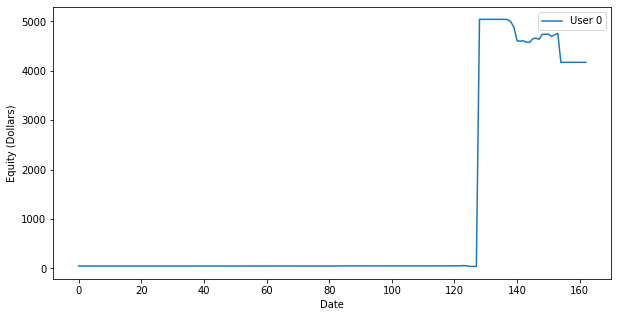

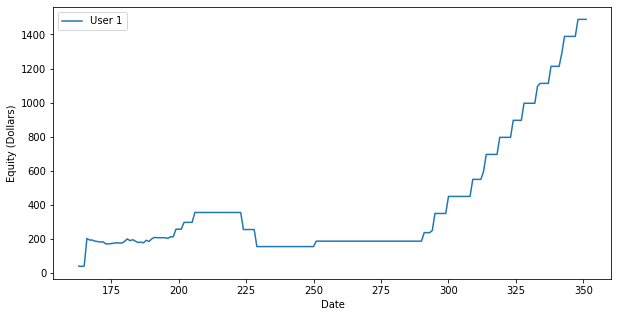

In [8]:
for i in range(2):
    user_eq_df=eq_df[eq_df['user_id']==eq_df[eq_df.columns[2]].unique()[i]]
    
    plt.figure(figsize=(10,5))
    
    ts=user_eq_df["close_equity"]
    time=user_eq_df["timestamp"]
    
    plt.xlabel('Date')
    plt.ylabel('Equity (Dollars)')
    plt.plot(ts, '-', label='User {0}'.format(i));
    plt.legend()
plt.show()

# We determine the two classes of the users - **Churned** or **Not Churned**. 
---
### To determine that, we make use of the condition that if the equity of a user is lower than $10 for 28 consecutive calendar days or longer.

From preliminary analysis of the equity value time-series of each user, we find that the minimum recorded equity value across users is \$10 and the maximum is ~\$4,50,000. This means that whenever the equity vaue goes below $10, those data are excluded from the table. This gives us an oppotunity to simplify the detection of churned users by simply determining the length of the missing time-series data for each user. If the length is over 28+2 (considering the weekend), that user is churned.

---

## The missing days (gap_days) from the dataset can be determined as shown below.

In [9]:
eq_df['gap_days'] = eq_df.timestamp.diff()
eq_df.head(10)

,timestamp,close_equity,user_id,gap_days
0,2016-11-16 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,NaT
1,2016-11-17 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
2,2016-11-18 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
3,2016-11-21 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,3 days
4,2016-11-22 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
5,2016-11-23 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
6,2016-11-25 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2 days
7,2016-11-28 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,3 days
8,2016-11-29 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
9,2016-11-30 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days


In [10]:
# The number of churned users is obtained by comparing the gap-days with a time-delta of 30 days.

churned_user_count=eq_df[eq_df['gap_days']>=pd.Timedelta("30 days")]['user_id'].nunique()
churned_user_ids=eq_df[eq_df['gap_days']>=pd.Timedelta("30 days")]['user_id'].unique()
print(len(churned_user_ids))

# Total users

total_users=eq_df['user_id'].nunique()
total_user_ids=eq_df['user_id'].unique()
print(len(total_user_ids))


279
5584


# **1. What fraction of the users have churned?**

In [11]:
frac=np.round(100.0*(churned_user_count/total_users), decimals=2)
print('Fraction of churned users is {0}%'.format(frac))

Fraction of churned users is 5.0%


# **Part 2: EDA and ML Model bulding to predict customer churn**




In [12]:
# The feature dataset

feat_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [13]:
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
dtypes: float64(2), object(7)
memory usage: 392.8+ KB


In [15]:
# Create a datset containing the class label(churn=1, no churn=0) by merging the churned user data with the 'feat_df'

churned_df=pd.DataFrame(churned_user_ids, columns=['user_id'])
churned_df['churn']=1
churned_df.head()

,user_id,churn
0,270cda53a026bcf6c2b98492b23c1b99,1
1,319c069e77187c7e7e7c027eb00fd941,1
2,ec84f134c5b27c4f5702803e98eb3f40,1
3,6dbedf7f2972b4f6ea60a15d48cb292c,1
4,91837d41270b81b267fc205c3e03ee9b,1


In [16]:
churned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  279 non-null    object
 1   churn    279 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


In [262]:
model_df=feat_df.merge(churned_df, how='left', on='user_id').fillna(0)
model_df['churn']=model_df['churn'].astype(int)
model_df=model_df.drop(['user_id'], axis=1)
model_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churn
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,0


In [235]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   churn                         5584 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 436.2+ KB


In [236]:
model_df.nunique()

risk_tolerance                     3
investment_experience              4
liquidity_needs                    3
platform                           3
time_spent                      4502
instrument_type_first_traded      11
first_deposit_amount             317
time_horizon                       3
churn                              2
dtype: int64

In [263]:
cat_df = model_df.select_dtypes(include=['object']).copy()

# Encoding the columns

enc_make = OrdinalEncoder()

cat_df_transformed = enc_make.fit_transform(cat_df)

for i,j in enumerate(cat_df.columns):
  cat_df[j] = cat_df_transformed.transpose()[i]

# Adding converted labels to df
for i in model_df.columns:
  if i in cat_df.columns:
    model_df[i] = cat_df[i]

model_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churn
0,0.0,2.0,2.0,0.0,33.129417,8.0,40.0,1.0,0
1,2.0,2.0,2.0,0.0,16.573517,8.0,200.0,2.0,0
2,2.0,2.0,2.0,2.0,10.008367,8.0,25.0,0.0,0
3,2.0,2.0,2.0,0.0,1.031633,8.0,100.0,2.0,0
4,0.0,2.0,2.0,0.0,8.187250,8.0,20.0,0.0,0


In [264]:
model_df.describe()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churn
count,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000
mean,0.679979,2.091332,1.708990,1.361927,34.509706,7.319305,633.566805,1.179083,0.049964
std,0.924629,0.755589,0.546611,0.882446,155.080551,1.850090,2118.323263,0.896479,0.217890
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,2.000000,0.000000,2.848908,8.000000,50.000000,0.000000,0.000000
50%,0.000000,2.000000,2.000000,2.000000,13.474708,8.000000,100.000000,2.000000,0.000000
75%,2.000000,3.000000,2.000000,2.000000,33.823829,8.000000,500.000000,2.000000,0.000000
max,2.000000,3.000000,2.000000,2.000000,8788.329450,10.000000,50000.000000,2.000000,1.000000


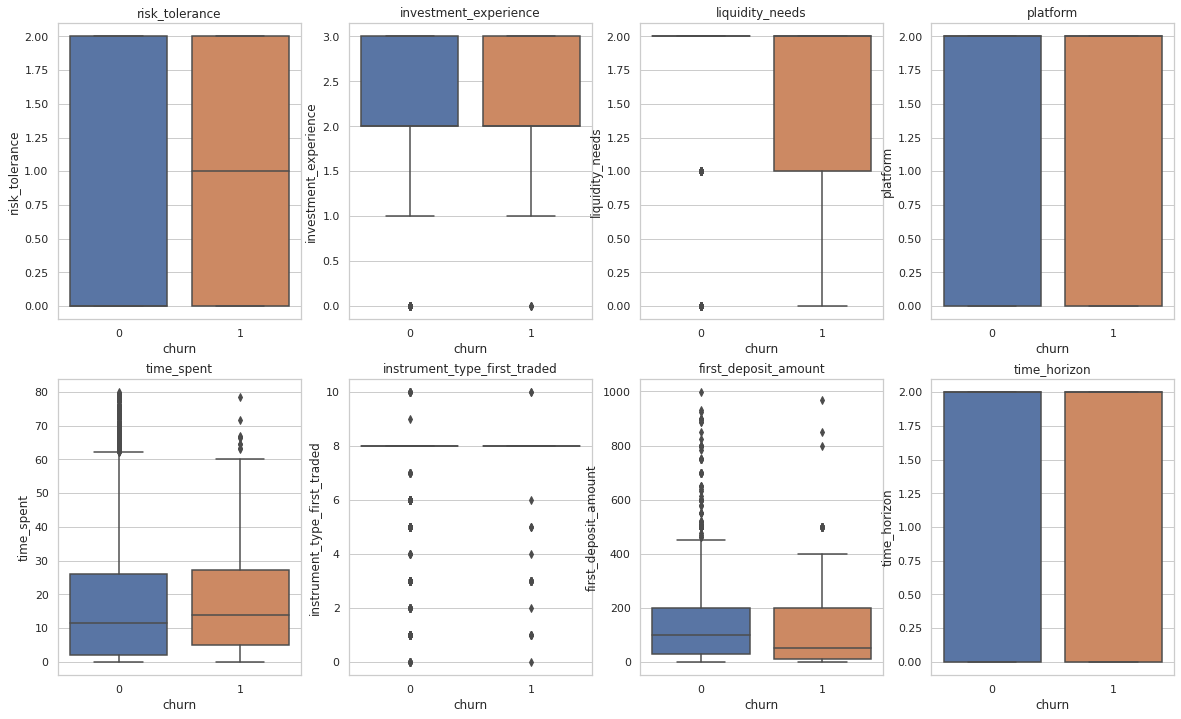

In [265]:
# Outlier detection using seaborn boxplot

model_df=model_df[(model_df['time_spent']<80) & (model_df['first_deposit_amount']<1000)] # Setting realistic outlier bounds

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(20, 12))

count=0
for i in range(2):
    for j in range(4):
        sns.boxplot(ax=axes[i, j],data=model_df, x='churn', y=model_df.columns[count])
        axes[i,j].set_title(model_df.columns[count])
        count+=1

# **Scaling of Data**

In [266]:
# Scaling of the non-objects

from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler

mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# We will use Robust scaler because it's ideal if there are outliers
for i in model_df.columns[:-1]:
  model_df[i] = mm_scaler.fit_transform(model_df[i].values.reshape(-1,1))
  # model_df["first_deposit_amount"] = mm_scaler.fit_transform(model_df["first_deposit_amount"].values.reshape(-1,1))

model_df.describe()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churn
count,4184.000000,4184.000000,4184.00000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000
mean,0.350502,0.719885,0.85086,0.696343,0.220835,0.735803,0.155298,0.596319,0.055927
std,0.466096,0.246491,0.27591,0.437036,0.236346,0.180390,0.175764,0.450564,0.229809
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.666667,0.50000,0.000000,0.029613,0.800000,0.025073,0.000000,0.000000
50%,0.000000,0.666667,1.00000,1.000000,0.144586,0.800000,0.100291,1.000000,0.000000
75%,1.000000,1.000000,1.00000,1.000000,0.328299,0.800000,0.200582,1.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


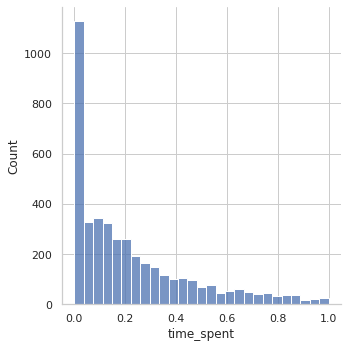

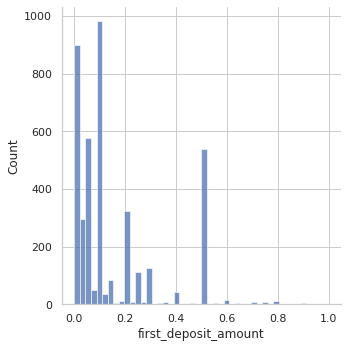

In [267]:
sns.displot(data=model_df, x="time_spent")
# plt.xlim(0,250)

sns.displot(data=model_df, x="first_deposit_amount")
# plt.xlim(0,2500)

plt.show()


## **Without removing the imbalance of the classes**

Churn events fraction in the data : 5.592734225621415
Non-churn events fraction in the data : 94.40726577437859


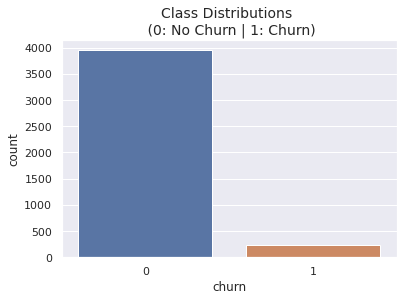

In [268]:
# Class balance

print('Churn events fraction in the data :',len(model_df[model_df['churn']==1])/len(model_df)*100)
print('Non-churn events fraction in the data :',len(model_df[model_df['churn']==0])/len(model_df)*100)

sns.set_theme(style="darkgrid")
g=sns.countplot(data=model_df, x='churn')

plt.title('Class Distributions \n (0: No Churn | 1: Churn)', fontsize=14)
plt.show()

# Class imbalance needs to be taken care before applying model

In [269]:
# Splitting the data

X = model_df.drop(columns = ['churn']) # 'user_id'
y = model_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X shape -', X_train.shape)
print('y shape -', y_train.shape)

X shape - (3347, 8)
y shape - (3347,)


# Feature selection using Chi-square for original, imbalanced data

Feature 0: 9.503448
Feature 1: 0.000200
Feature 2: 0.047427
Feature 3: 0.005039
Feature 4: 0.005776
Feature 5: 0.000598
Feature 6: 1.218599
Feature 7: 0.902191


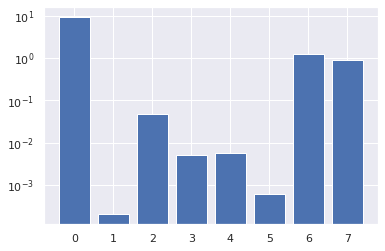

In [270]:
# Chi squared feature selection for categorical data
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
 
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.yscale('log')
plt.show()

### Random Forest with a single validation data

In [271]:
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

print("Accuracy (in %):", clf.score(X_test, y_test)*100)

# y_pred = clf.predict(X_test)
y_pred = (clf.predict_proba(X_test)[:,1] >= 0.1).astype(bool)
print('F1 score', f1_score(y_test, y_pred))

print('AUC Score = ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.show()

Accuracy (in %): 93.78733572281959
F1 score 0.0891089108910891
AUC Score =  0.569157275845174




## Poor performance from imbalanced data. No surprises here.
Let's check the feature importance for the classifier





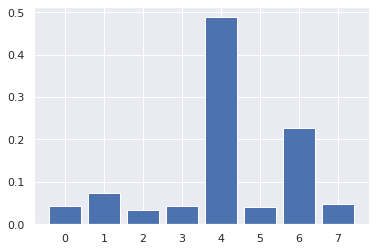

In [272]:
importance=clf.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Balancing the classes by **undersampling**

In [273]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Number of fraud classes are fraud_len

churn_df = model_df[model_df['churn'] == 1]
churn_len=len(churn_df)
non_churn_df = model_df[model_df['churn'] == 0][:churn_len]

balanced_df = pd.concat([churn_df, non_churn_df])

# Shuffle 
new_df = balanced_df.sample(frac=1, random_state=None)

new_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churn
313,0.0,0.333333,0.0,1.0,0.098158,0.8,0.100291,1.0,0
5244,1.0,0.666667,1.0,0.5,0.020123,0.8,0.010029,0.0,1
169,0.0,0.666667,1.0,1.0,0.109469,0.8,0.200582,1.0,0
311,0.5,0.333333,0.0,1.0,0.034451,0.8,0.100291,1.0,0
26,0.0,0.333333,1.0,0.0,0.239516,0.8,0.010029,0.0,0


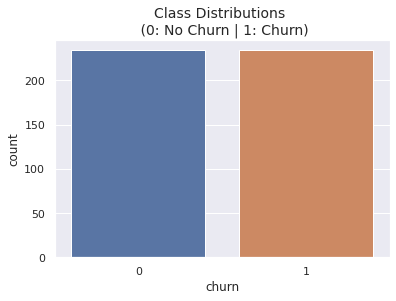

In [274]:
# Classes balanced

sns.set_theme(style="darkgrid")
sns.countplot(data=new_df, x='churn')
plt.title('Class Distributions \n (0: No Churn | 1: Churn)', fontsize=14)
plt.show()

In [275]:
X=new_df.drop(columns = ['churn'], axis=1)
y=new_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(374, 8)
(94, 8)


Feature 0: 4.573275
Feature 1: 0.051420
Feature 2: 0.000778
Feature 3: 0.012974
Feature 4: 0.007506
Feature 5: 0.007685
Feature 6: 0.331475
Feature 7: 0.048129


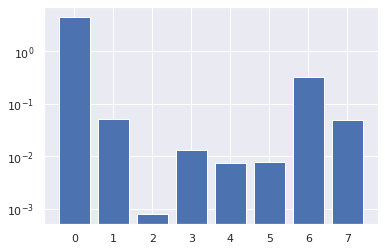

In [276]:
# Chi squared feature selection for categorical data

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
 
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.yscale('log')
plt.show()

Accuracy (in %): 56.38297872340425
F1 score 0.5591397849462365
AUC Score =  0.550595238095238


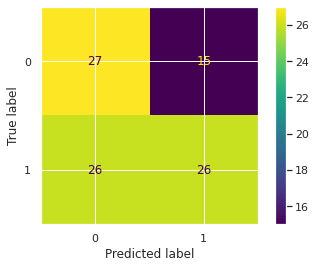

In [277]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

print("Accuracy (in %):",clf.score(X_test, y_test)*100)

y_pred = clf.predict(X_test)
print('F1 score', f1_score(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test)  

print('AUC Score = ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.show()

[0.06802852 0.09423407 0.05240626 0.06497213 0.33740552 0.04179754
 0.27174852 0.06940746]


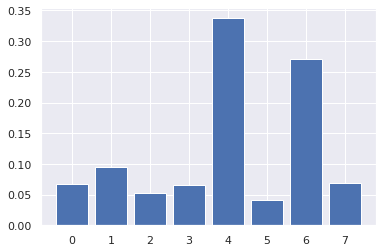

In [278]:
# Let's check the feature importance

importance=clf.feature_importances_
print(importance)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## **Balancing the classes by undersampling improved the performance. However, the F1 score average is still only 0.53. Not good enough.**

# **Random Oversampling**

In [279]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Imbalanced data

X = model_df.drop(columns = ['churn'])
y = model_df['churn']

# Class distribution
print(Counter(y))

# Oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# Fitting and applying the transforms
X_over, y_over = oversample.fit_resample(X, y)

# summarize class distribution
print(Counter(y_over))

Counter({0: 3950, 1: 234})
Counter({0: 3950, 1: 3950})


In [280]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

print(X_train.shape, ', ',X_test.shape)
print(y_train.shape, ', ',y_test.shape)

(6320, 8) ,  (1580, 8)
(6320,) ,  (1580,)


Accuracy (in %): 97.34177215189874
F1 score 0.9737499999999999
AUC Score =  0.9989687152933031


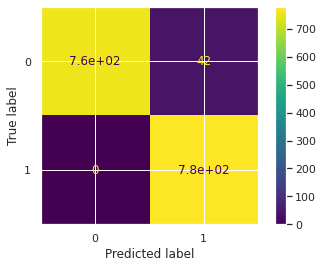

In [281]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)

print("Accuracy (in %):",clf.score(X_test, y_test)*100)

y_pred = clf.predict(X_test)
print('F1 score', f1_score(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test)  

print('AUC Score = ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.show()

# SMOTE to oversample the minority classes for better prediction

In [282]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where

# Imbalanced data reloaded for oversampling

X = model_df.drop(columns = ['churn'])
y = model_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)


(3347, 8)
(6320, 8)


Feature 0: 77.083109
Feature 1: 0.061814
Feature 2: 0.087198
Feature 3: 0.053253
Feature 4: 0.322820
Feature 5: 0.339023
Feature 6: 21.351943
Feature 7: 0.639660


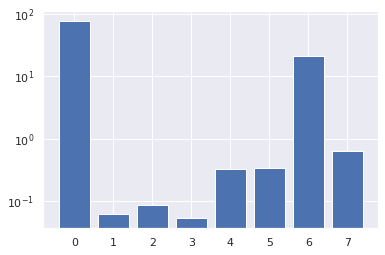

In [283]:
# Chi squared feature selection for categorical data

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
 
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.yscale('log')
plt.show()

Accuracy (in %): 93.29113924050633
F1 score 0.9323979591836734
AUC Score =  0.9814569080049168


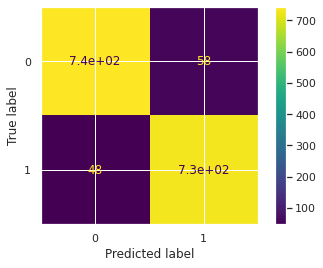

In [284]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

print("Accuracy (in %):",clf.score(X_test, y_test)*100)

y_pred = clf.predict(X_test)
print('F1 score', f1_score(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test)  

print('AUC Score = ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.show()

[0.05468652 0.14706196 0.05391023 0.05025953 0.26711757 0.05051182
 0.31207145 0.0643809 ]


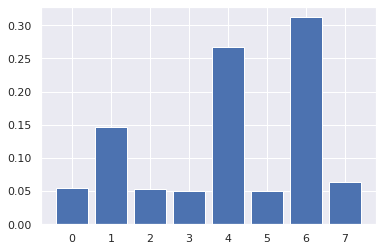

In [285]:
# Let's check the feature importance

importance=clf.feature_importances_
print(importance)
plt.bar([x for x in range(len(importance))], importance)
plt.show()